In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import Perceptron
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import random
import itertools
import seaborn as sns

sns.set(style = 'darkgrid')
% matplotlib inline

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
up = pd.read_excel('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\Upset.xlsx', sheet = 'Upset')

In [5]:
up.head(1)

,Numot,Season,game_id,host_lat,host_long,host_site,season,Upset,team1_win,team1_id,...,team2_pt_school_ff,team2_pt_overall_ff,team2_pt_career_school_wins,team2_pt_career_school_losses,team2_pt_career_overall_losses,team2_pt_team_season_wins,team2_pt_team_season_losses,team2_pt_coach_season_wins,team2_pt_coach_season_losses,result
0,0,2003,2003-1112-1242,33.8361,-117.8897,Anaheim,2003,0,0,1112,...,3,3,413,100,100,25,7,25,7,0


In [6]:
up.columns

Index(['Numot', 'Season', 'game_id', 'host_lat', 'host_long', 'host_site',
       'season', 'Upset', 'team1_win', 'team1_id',
       ...
       'team2_pt_school_ff', 'team2_pt_overall_ff',
       'team2_pt_career_school_wins', 'team2_pt_career_school_losses',
       'team2_pt_career_overall_losses', 'team2_pt_team_season_wins',
       'team2_pt_team_season_losses', 'team2_pt_coach_season_wins',
       'team2_pt_coach_season_losses', 'result'],
      dtype='object', length=147)

In [7]:
up_r = up.ix[:,13:44]
up_r['R_dist'] = np.log1p(up['R_dist'])
up_r['R_seed'] = np.log1p(up['R_seed'])
up_r['upset'] = up['Upset']
up_r['team1_win'] = up['team1_win']
up_r.head(1)

,R_seed,R_lat,R_long,R_dist,R_fg2pct,R_fg3pct,R_ftpct,R_blockpct,R_oppfg2pct,R_oppfg3pct,...,R_adjde,R_rpi_rating,R_adjRPI,R_ascore,R_aagainst,R_ato,R_ashoot,R_a3shoot,upset,team1_win
0,0.405465,0.827368,1.164888,0.267559,0.950253,1.060465,1.087345,0.83242,1.058932,0.877411,...,1.022211,1.0144,0.991728,1.053075,0.993385,0.905172,1.006757,1.08449,0,0


mup_r = pd.melt(up_r, "team1_win", var_name="measurement")
fig, ax = plt.subplots(figsize=(10,5))
p = sns.violinplot(ax=ax, x="measurement", y="value", hue="team1_win", split = True, data=mup_r, inner = 'quartile', palette = 'Set2');
p.set_xticklabels(rotation = 90, labels = list(up_r.columns));

In [8]:
X = up_r.ix[:,:31]
y = up_r['team1_win']
model = ExtraTreesClassifier()
model.fit(X, y)
z = pd.DataFrame(model.feature_importances_, columns = ['score'])
z['feature'] = list(X.columns)
z = z.sort(columns = 'score', ascending = False)
print(model.score(X,y))
feats = list(z['feature'])
z.head()

1.0


C:\Users\Travis Park\Anaconda3_1\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,score,feature
0,0.134310,R_seed
25,0.061205,R_adjRPI
23,0.048815,R_adjde
21,0.046659,R_adjoe
20,0.046540,R_oe


In [9]:
up_season = up_r[['R_seed', 'R_rpi_rating', 'R_adjRPI', 'R_ascore', 'R_aagainst', 'R_ato','R_ashoot','R_a3shoot']]
up_f = up_r[feats]
up_f['team1_win'] = up_r['team1_win']
up_f.head(1)

C:\Users\Travis Park\Anaconda3_1\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,R_seed,R_adjRPI,R_adjde,R_adjoe,R_oe,R_rpi_rating,R_arate,R_lat,R_oppftpct,R_oppblockpct,...,R_ashoot,R_oppfg2pct,R_adjtempo,R_dist,R_oppstlrate,R_ftpct,R_f3grate,R_tempo,R_a3shoot,team1_win
0,0.405465,0.991728,1.022211,1.024358,1.009938,1.0144,1.068719,0.827368,0.925248,0.634667,...,1.006757,1.058932,1.011828,0.267559,0.871932,1.087345,1.335265,1.028359,1.08449,0


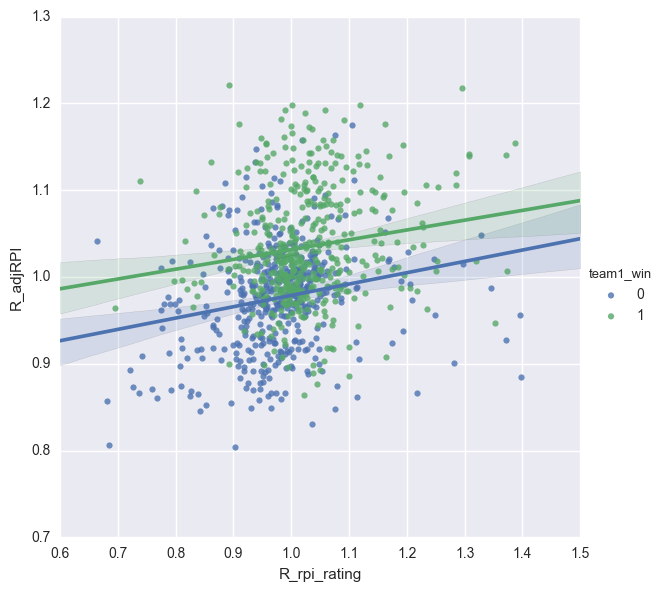

In [10]:
sns.lmplot(x = 'R_rpi_rating', y = 'R_adjRPI',  hue='team1_win', size = 6, data = up_f);

sns.jointplot(x = up_f['R_seed'], y = up_f['R_oppfg2pct'], kind='reg', color="#4CB391", size = 6);

In [11]:
X = up_season.ix[:,:]
y = up_f['team1_win']
class_names = list(y.unique())

In [12]:
X.columns

Index(['R_seed', 'R_rpi_rating', 'R_adjRPI', 'R_ascore', 'R_aagainst', 'R_ato',
       'R_ashoot', 'R_a3shoot'],
      dtype='object')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler() 
scaler.fit(X_train)
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [14]:
kmeans = KMeans(n_clusters = 5, random_state = 0)

kmeans_pred = kmeans.fit(X_train).predict(X_test)
#kmeans.score(X_train,y_train), kmeans.score(X_test, y_test),kmeans.score(X_train,y_train)-kmeans.score(X_test,y_test)

clust = kmeans.fit(X).predict(X)
X['Clust'] = clust
up_f['Clust'] = clust
up_season['Clust'] = clust

C:\Users\Travis Park\Anaconda3_1\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Travis Park\Anaconda3_1\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
c_score = pd.DataFrame(up_f.pivot_table(index = 'Clust', values = 'team1_win', aggfunc = np.mean))
c_score = c_score.reset_index()
c_score

,Clust,team1_win
0,0,0.434615
1,1,0.250000
2,2,0.713333
3,3,0.065934
4,4,0.807229


In [16]:
X = pd.merge(X,c_score, how = 'left', left_on = 'Clust',right_on = 'Clust')
#X = X.drop('team1_win_y', axis = 1)
#X = X.drop('team1_win_x', axis = 1)
X = X.drop('Clust', axis = 1)

up_season = pd.merge(up_season,c_score, how = 'left', left_on = 'Clust',right_on = 'Clust')
#up_season = up_season.drop('team1_win_y', axis = 1)
#up_season = up_season.drop('team1_win_x', axis = 1)
up_season = up_season.drop('Clust', axis = 1)

In [17]:
up_season.head(1)

,R_seed,R_rpi_rating,R_adjRPI,R_ascore,R_aagainst,R_ato,R_ashoot,R_a3shoot,team1_win
0,0.405465,1.0144,0.991728,1.053075,0.993385,0.905172,1.006757,1.08449,0.713333


In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914 entries, 0 to 913
Data columns (total 9 columns):
R_seed          914 non-null float64
R_rpi_rating    914 non-null float64
R_adjRPI        914 non-null float64
R_ascore        914 non-null float64
R_aagainst      914 non-null float64
R_ato           914 non-null float64
R_ashoot        914 non-null float64
R_a3shoot       914 non-null float64
team1_win       914 non-null float64
dtypes: float64(9)
memory usage: 71.4 KB


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler() 
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [20]:
m_eval = pd.DataFrame(columns = ['method','trainscore','testscore','truepos','trueneg'])

In [21]:
def addeval(method, train, test, tpos, tneg):
    global m_eval
    d = pd.DataFrame([[method, train, test, tpos, tneg]],columns = ['method','trainscore','testscore','truepos','trueneg'])
    m_eval = m_eval.append(d)

# SVC

In [22]:
###SVC
svc = SVC(kernel = 'rbf',C=1, gamma=.1, probability = True)
#svc.fit(X,y)
svc_pred = svc.fit(X_train, y_train).predict(X_test)
t = pd.DataFrame(svc.predict_proba(X_test))
svc.score(X_train,y_train), svc.score(X_test, y_test),svc.score(X_train,y_train)-svc.score(X_test,y_test)

(0.72058823529411764, 0.7185430463576159, 0.0020451889365017406)

In [23]:
mtrx = confusion_matrix(y_test,svc_pred)
mtrx

array([[121,  19],
       [ 66,  96]])

In [24]:
addeval('SVC',svc.score(X_train,y_train), svc.score(X_test, y_test),mtrx[0,0],mtrx[1,1])

# Neural Net

In [25]:
###Neural Net
nn = MLPClassifier(solver='adam', activation = 'logistic',hidden_layer_sizes=(20, 15), random_state=1)

nn_pred = nn.fit(X_train,y_train).predict(X_test)
nn.score(X_train,y_train), nn.score(X_test,y_test), nn.score(X_train,y_train)-nn.score(X_test,y_test)

(0.70915032679738566, 0.71523178807947019, -0.0060814612820845326)

In [26]:
mtrx = confusion_matrix(y_test,nn_pred)
mtrx

array([[118,  22],
       [ 64,  98]])

In [27]:
addeval('Neural Net',nn.score(X_train,y_train), nn.score(X_test, y_test),mtrx[0,0],mtrx[1,1])

# Extra Trees

In [28]:
###ETC
etc = ExtraTreesClassifier()
etc_pred = etc.fit(X_train,y_train).predict(X_test)
etc.score(X_train,y_train), etc.score(X_test,y_test), etc.score(X_train,y_train)-etc.score(X_test,y_test)

(1.0, 0.67218543046357615, 0.32781456953642385)

In [29]:
mtrx = confusion_matrix(y_test,etc_pred)
mtrx

array([[110,  30],
       [ 69,  93]])

In [30]:
addeval('Extra Trees',etc.score(X_train,y_train), etc.score(X_test, y_test),mtrx[0,0],mtrx[1,1])

# Adaptive Boosting

In [31]:
###Adaptive Boosting
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=600,learning_rate=1)

ada_pred = ada.fit(X_train,y_train).predict(X_test)
ada.score(X_train,y_train), ada.score(X_test,y_test), ada.score(X_train,y_train)-ada.score(X_test,y_test)

(1.0, 0.65231788079470199, 0.34768211920529801)

In [32]:
mtrx = confusion_matrix(y_test,ada_pred)
mtrx

array([[104,  36],
       [ 69,  93]])

In [33]:
addeval('Ada',ada.score(X_train,y_train), ada.score(X_test, y_test),mtrx[0,0],mtrx[1,1])

# KNN

In [34]:
knn = KNeighborsClassifier(n_neighbors = 14, algorithm = 'auto', weights = 'uniform')
knn_pred = knn.fit(X_train, y_train).predict(X_test)
knn.score(X_train,y_train), knn.score(X_test,y_test), knn.score(X_train,y_train)-knn.score(X_test,y_test)

(0.70261437908496727, 0.68543046357615889, 0.017183915508808378)

In [35]:
mtrx = confusion_matrix(y_test,knn_pred)
mtrx

array([[118,  22],
       [ 73,  89]])

In [36]:
addeval('KNN',knn.score(X_train,y_train), knn.score(X_test, y_test),mtrx[0,0],mtrx[1,1])

# Gaussian NB 

In [37]:
gauss = GaussianNB()
gauss_pred = gauss.fit(X_train, y_train).predict(X_test)
gauss.score(X_train,y_train), gauss.score(X_test,y_test), gauss.score(X_train,y_train)-gauss.score(X_test,y_test)

(0.69607843137254899, 0.72847682119205293, -0.032398389819503937)

In [38]:
mtrx = confusion_matrix(y_test,gauss_pred)
mtrx

array([[114,  26],
       [ 56, 106]])

In [39]:
addeval('GaussNB',gauss.score(X_train,y_train), gauss.score(X_test, y_test),mtrx[0,0],mtrx[1,1])

# Perceptron

In [40]:
perc = Perceptron(verbose=0, alpha = 0.1, fit_intercept = True, class_weight = 'balanced')
perc_pred = perc.fit(X_train, y_train).predict(X_test)
perc.score(X_train,y_train), perc.score(X_test,y_test), perc.score(X_train,y_train)-perc.score(X_test,y_test)

(0.65196078431372551, 0.66887417218543044, -0.016913387871704932)

In [41]:
mtrx = confusion_matrix(y_test,perc_pred)
mtrx

array([[ 92,  48],
       [ 52, 110]])

In [42]:
addeval('Perc',perc.score(X_train,y_train), perc.score(X_test, y_test),mtrx[0,0],mtrx[1,1])

# Stochastic Gradient Descent

In [43]:
sgd = SGDClassifier(loss = 'squared_hinge')
sgd_pred = sgd.fit(X_train, y_train).predict(X_test)
sgd.score(X_train,y_train), sgd.score(X_test,y_test), sgd.score(X_train,y_train)-sgd.score(X_test,y_test)

(0.67810457516339873, 0.69867549668874174, -0.020570921525343011)

In [44]:
mtrx = confusion_matrix(y_test,sgd_pred)
mtrx

array([[104,  36],
       [ 55, 107]])

In [45]:
addeval('SGD',sgd.score(X_train,y_train), sgd.score(X_test, y_test),mtrx[0,0],mtrx[1,1])

In [46]:
m_eval

,method,trainscore,testscore,truepos,trueneg
0,SVC,0.720588,0.718543,121.0,96.0
0,Neural Net,0.709150,0.715232,118.0,98.0
0,Extra Trees,1.000000,0.672185,110.0,93.0
0,Ada,1.000000,0.652318,104.0,93.0
0,KNN,0.702614,0.685430,118.0,89.0
0,GaussNB,0.696078,0.728477,114.0,106.0
0,Perc,0.651961,0.668874,92.0,110.0
0,SGD,0.678105,0.698675,104.0,107.0


In [47]:
mm1_eval = pd.melt(m_eval[['method','truepos','trueneg']], "method", var_name="measurement")
mm2_eval = pd.melt(m_eval[['method','trainscore','testscore']], "method", var_name="measurement")

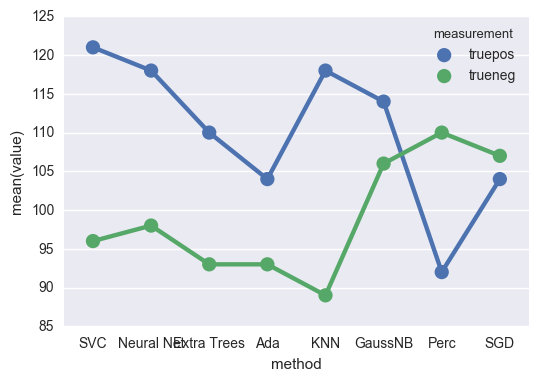

In [48]:
sns.pointplot(x="method", y="value", hue="measurement", data=mm1_eval);

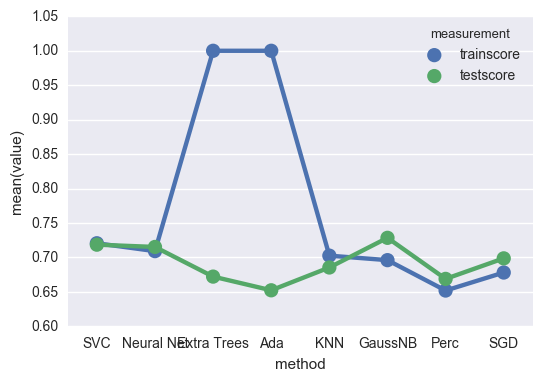

In [49]:
sns.pointplot(x="method", y="value", hue="measurement", data=mm2_eval);

mtrx = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision = 2)

sns.set(style = 'white')
plt.figure()
plot_confusion_matrix(mtrx,classes=class_names,title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(mtrx, classes=class_names, normalize = True, title='Normalized confusion matrix')

#plt.show()

up_season = scaler.transform(up_season)

t = pd.DataFrame(svc.predict_proba(up_season), columns = ['predicted','inverse'])
up_season['predicted'] = t['inverse']
up['predicted'] = t['inverse']

up_season.head(1)

log_loss(up['team1_win'],up['predicted'])

p = sns.PairGrid(up_season, hue = 'team1_win', palette = 'Reds')
p.map_upper(plt.scatter, s = 20, edgecolor = 'w')
p.map_diag(plt.hist)
p.map_lower(plt.scatter, s = 20, edgecolor = 'w')
p.add_legend()

p.figsize = (30,30)

In [50]:
#up.to_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\Predictions\\SVM1.csv')

matchs.to_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\teams.csv')


**Predict All Possible Matchups**

In [51]:
up_pred = pd.read_excel('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\Frame.xlsx', sheet = 'Sheet1')

In [52]:
years = [2013,2014,2015,2016]

In [53]:
up_pred = up_pred[(up_pred['Year'].isin(years))]
tup = up_pred.ix[:,4:12]
list(tup.columns)

['R_seed',
 'R_rpi_rating',
 'R_adjRPI',
 'R_ascore',
 'R_aagainst',
 'R_ato',
 'R_shoot',
 'R_3shoot']

In [54]:
clust = kmeans.predict(tup)
tup['Clust'] = clust
tup.head()

tup = pd.merge(tup,c_score, how = 'left', left_on = 'Clust',right_on = 'Clust')
tup = tup.drop('Clust',axis = 1)

In [55]:
p = pd.DataFrame(nn.predict_proba(tup),columns = ['predicted','inverse'])
q = pd.DataFrame(svc.predict_proba(tup),columns = ['predicted','inverse'])

In [56]:
len(tup),len(p)

(9112, 9112)

In [57]:
up_pred['nnpred'] = p['inverse']
up_pred['svcpred'] = q['inverse']
#up_pred['scale'] = minmax_scale(up_pred['nnpred'], feature_range=(0.4,0.6),axis = 0, copy = True)
up_pred.head()

,Year,Team1,Team2,id,R_seed,R_rpi_rating,R_adjRPI,R_ascore,R_aagainst,R_ato,...,1seed2,1rpi2,1adjrpi2,1ascore2,1aagainst2,1ato2,1ashoot2,1a3shoot3,nnpred,svcpred
0,2013,1231,1274,2013_1231_1274,0.500000,0.991455,0.995917,1.009688,1.057272,1.144715,...,2,0.635635,0.639878,73.818182,67.090909,11.181818,0.462054,0.388611,0.500089,0.455578
1,2013,1231,1266,2013_1231_1266,0.333333,1.041433,1.045860,1.175890,1.072248,0.885106,...,3,0.605131,0.609322,63.384615,66.153846,14.461538,0.449383,0.309510,0.551681,0.526845
2,2013,1231,1393,2013_1231_1393,0.250000,1.018958,1.020402,1.216540,1.125926,0.989691,...,4,0.618478,0.624524,61.266667,63.000000,12.933333,0.411019,0.318593,0.548896,0.534071
3,2013,1231,1424,2013_1231_1424,0.200000,1.046843,1.049933,1.063677,1.028019,0.909645,...,5,0.602004,0.606958,70.071429,69.000000,14.071429,0.419632,0.334719,0.559503,0.524480
4,2013,1231,1301,2013_1231_1301,0.125000,1.056074,1.061715,0.990476,0.875720,1.003922,...,8,0.596742,0.600222,75.250000,81.000000,12.750000,0.492305,0.401633,0.580367,0.526234


In [58]:
#up_pred[['id','nnpred','svcpred']].to_csv('C:\\Users\\Travis Park\\Google Drive\\Spring 2017\\March Madness\\Data\\Predictions\\Kagglesub5.csv')